# Baywheels Ride data findings

## by Sahithi Indarapu

Dataset : https://www.lyft.com/bikes/bay-wheels/system-data

## Investigation Overview

My goals for this investigation were to understand how various factors affect the ride counts and to discover concrete patterns that help drive business decisions. I also wanted to find out what are good trends (and what are not) with the riders.

## Dataset Overview

FordGo bike data as the name suggests is a bike ride data. The data is pretty descriptive and easy to understand. This specific jupyter notebook here is dealing with bike sharing data from 2017 to 2019. The data collected here is informative sparing few missing values. The project here follows all the four steps of data analysis process where the data is gathered, cleaned (quality and tidyness), lastly analyzed and visualised. The dataset has below columns :

- Trip Duration (seconds)
- Start Time and Date
- End Time and Date
- Start Station ID
- Start Station Name
- Start Station Latitude
- Start Station Longitude
- End Station ID
- End Station Name
- End Station Latitude
- End Station Longitude
- Bike ID

I added few more columns to the above original dataset to make analysis easier such as extracting year, month, weekday from the start date.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [3]:
df = pd.read_csv("baywheels_clean.csv")
df.sample(5)

,duration_sec,start_time,bike_id,user_type,bike_share_for_all_trip,rental_access_method,duration_min,ride_year,ride_month,ride_weekday,ride_hour
3703206,1539,2020-01-28 17:38:57,242339,Subscriber,NaN,app,26,2020,Jan,Tue,17
1244968,6109,2017-09-10 20:34:52.069,2126,Customer,NaN,NaN,102,2017,Sep,Sun,20
218367,5598,2019-09-16 12:38:15.241,2834,Subscriber,Yes,NaN,94,2019,Sep,Mon,12
43078,310,2018-02-16 05:10:52.867,2707,Subscriber,Yes,NaN,6,2018,Feb,Fri,5
2182207,158,2019-06-19 22:42:50.581,501,Subscriber,No,NaN,3,2019,Jun,Wed,22


In [6]:
# mark category variables

sorted_months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
sorted_weekdays = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

cat_months = pd.api.types.CategoricalDtype(categories=sorted_months, ordered=True)
cat_weekdays = pd.api.types.CategoricalDtype(categories=sorted_weekdays, ordered=True)

# Mark month and weekday as category variable
df.ride_year = df.ride_year.astype('category')
df.ride_month = df.ride_month.astype(cat_months)
df.ride_weekday = df.ride_weekday.astype(cat_weekdays)
df.ride_hour = df.ride_hour.astype('category')



## Ride duration frequency

Since Baywheels bills the rides by minutes, it makes sense to perform analysis on what are the highest durations people use a single ride for. Looking at the graph, it can be clearly seen that ~4M rides are less than 15 minutes. Since the number of rides decreased exponentially as the duration increases, I had to plot the data on a logarthmic scale. This graph shows that:

- Out of 5.2M rides, close to 4M are from rides less than 15minutes and nearly 1M are between 15mins to 30mins duration.
- There are some considerable amount of rides that span up to 8h which makes sense because people might be using the bike for entire day (8 hours). The graph consistently steeps up to 8h mark.
- After 9h mark, the graph nearly flattens out with no significant decrease. This may be interesting and it can be used to perhaps do some more deeper user based analysis and baywheels can use the user data from these rides for some targetted promotions.

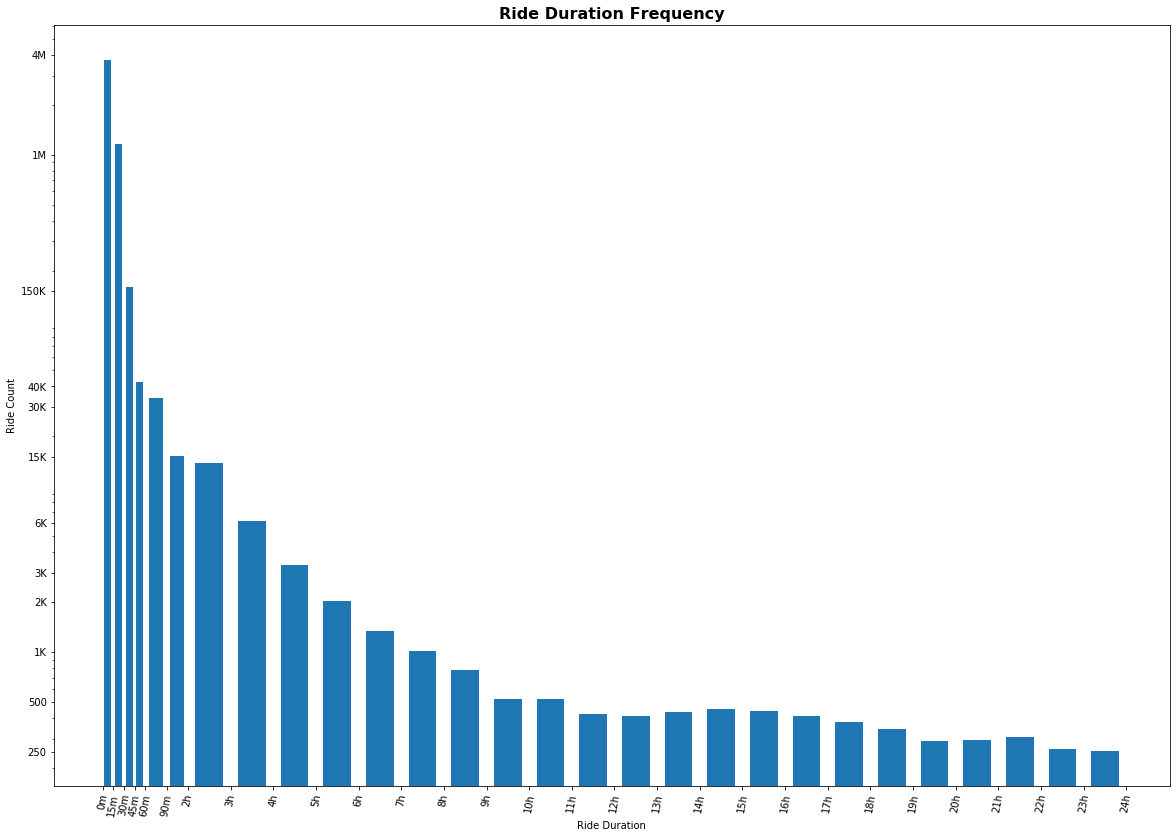

In [9]:
less_than_a_day = df.query('duration_min < 24 * 60').duration_min # There are only two rides that are greater than 24h
plt.figure(figsize=(20,14))
yticks = [ 250, 500, 1000, 2000, 3000, 6000, 15000, 30000, 40000, 150000, 1000000, 4000000]
ylabels = [ 250, 500, "1K", "2K", "3K", "6K", "15K", "30K", "40K", "150K", "1M", "4M"]

xticks = [ 0, 15, 30, 45, 60, 90 ]
xticks.extend([*range(120, 1500, 60)])

def fmtxlabel(l):
    if l <= 90:
        return "{}m".format(l)
    else:
        return "{}h".format(int(l/60))

xlabels = list(map(lambda x : fmtxlabel(x), xticks))
plt.hist(less_than_a_day, bins = xticks, rwidth = 0.65)
plt.yscale('log')
plt.yticks(yticks, labels = ylabels);
plt.xticks(xticks, labels = xlabels, rotation=80)
plt.xlabel("Ride Duration")
plt.ylabel("Ride Count")
plt.title("Ride Duration Frequency", fontsize = 16, fontweight = 'bold');

## Duration(in mins) by user type (Bivariate)

Looking at the these box plots, it is clear that customers usually keep the bike for longer durations compared to the subscribers. This can be used to target marketing based on ride duration between subscribers and customers differently. The median for subscriber rides is around 10mins whereas the median for customer rides is around 15 minutes. There are a lot of outliers in the graph which echoes the previous graph that most rides are less than 30 minutes.

<Figure size 864x864 with 0 Axes>

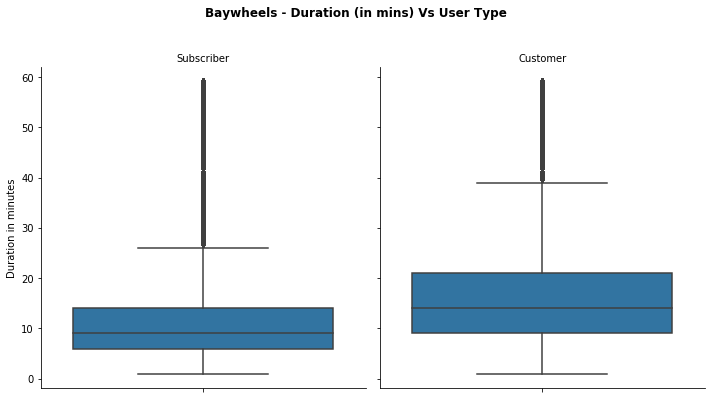

In [8]:
# 60mins is reasonable because nearly 90% of the rides are in < 30mins category.
less_than_hour = df.query('duration_min < 60')

plt.figure(figsize=(12,12));
boxplot = sb.catplot(kind = 'box', data = less_than_hour, y = 'duration_min', col = 'user_type')
boxplot.set_axis_labels("", "Duration in minutes")
boxplot.fig.suptitle("Baywheels - Duration (in mins) Vs User Type", y = 1.1, fontweight = 'bold')
boxplot.set_titles(col_template = '{col_name}');

## Heatmap for Customer & Subscriber weekday rides by hour of the day. (Multivariate)

Following deductions from heatmaps:

- Customers and Subscribers peak during the commute hours on weekdays
- Customer rides increase during weekends and Subscriber rides decrease during weekends
- On the weekends, Customer rides spike around noon-ish and the heatmap is generally denser throughout the day.
- Irrespective of user type, there are very less rides during off hours (11 PM to 5 AM) generally.

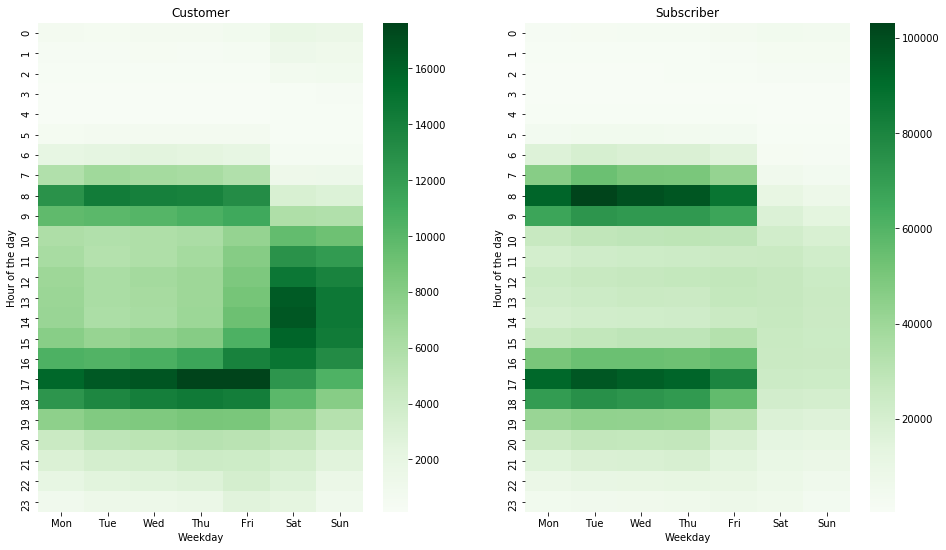

In [7]:
# heatmap for weekeday vs hour of day for customers and subscribers.
plt.figure(figsize=(16, 9))
graphs = [(1, 'Customer'), (2, 'Subscriber')]
for g in graphs:
    plt.subplot(1, 2, g[0])
    custs = df[df.user_type == g[1]].groupby(["ride_hour", "ride_weekday"]).size().reset_index()
    custs.rename(columns = {0: 'count'}, inplace=True)
    custs = custs.pivot(index = 'ride_hour', columns = 'ride_weekday', values = 'count')
    sb.heatmap(custs, cmap='Greens')
    plt.title(g[1])
    plt.xlabel("Weekday")
    plt.ylabel("Hour of the day")

## Conclusions

In the exploration of baywheels dataset, I have made following conclusions:

- There are two types of users - Customers and Subscribers. These two user groups vary significantly in their usage behaviour. Most usage usually happens around commute hours. And Customer usage peaks during weekends while subscriber usage peaks during weekdays (and especially during commute hours).
- Summer months usually have high usage compared to holiday season or winter months. But this was not highly consistent across years speaking to the true Bay area weather!
- Clipper card adaption is still very low as most riders prefer paying via App.
- Bay area all wheels program is quite recent and it would be interesting to see how the program grows.

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!